# Coletando imagens do RPG Maker

.

Este _notebook_ é parte do trabalho [pixel sides](pixel-sides.ipynb). Ele descreve a coleta de imagens provenientes do RPG Maker 2000
para gerar um pequeno _dataset_ de imagens de personagens em _pixel art_ no tamanho $(64, 64, 4)$.

In [3]:
from PIL import Image
import os

def crop(file_path, tile_height, tile_width):
    image = Image.open(file_path)
    image = image.convert("RGBA")
    image_width, image_height = image.size
    for i in range(image_height // tile_height):
        for j in range(image_width // tile_width):
            tile = (j*tile_width, i*tile_height, (j+1)*tile_width, (i+1)*tile_height)
            yield image.crop(tile), i, j

def replace_color(data_array, source_color, target_color):
    red, green, blue, alpha = data_array.T
    color_key_mask = (red == source_color[0]) & (green == source_color[1]) & (blue == source_color[2])
    data_array[color_key_mask.T] = target_color
    return data_array




## Gerando _dataset_ de _CharSets_ do RPG Maker 2000

Processou Actor1.png gerando 96 novas imagens de entrada
Processou Actor2.png gerando 96 novas imagens de entrada
Processou Actor3.png gerando 96 novas imagens de entrada
Processou Actor4.png gerando 96 novas imagens de entrada
Processou People1.png gerando 96 novas imagens de entrada
Processou People2.png gerando 96 novas imagens de entrada
Processou People3.png gerando 96 novas imagens de entrada
Processou People4.png gerando 96 novas imagens de entrada
Processou People5.png gerando 96 novas imagens de entrada
Fim!


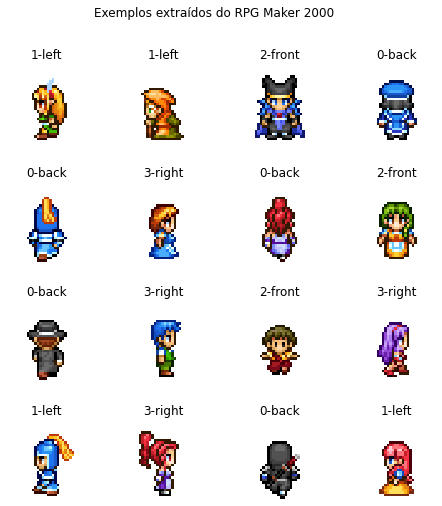

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from io_utils import ensure_folder_structure

folder = "./sources-for-datasets/RPG Maker 2000 RTP/CharSet"
files = ["Actor1.png", "Actor2.png", "Actor3.png", "Actor4.png", "People1.png", "People2.png", "People3.png", "People4.png", "People5.png"]
height = 32
width = 24
color_key = (32, 156, 0)
pad_vertical = (64 - 64) // 2
pad_horizontal = (64 - 48) // 2
padding = ((pad_vertical, pad_vertical), (pad_horizontal, pad_horizontal), (0, 0))
sample_images = []
sample_labels = []
row_to_folder_mapping = ["0-back", "3-right", "2-front", "1-left"]

for file_name in files:
    tiles = 0
    for k, (data, i, j) in enumerate(crop(os.path.join(folder, file_name), height, width)):
        # pega apenas j%3 == 1 (parado, sem estar andando)
#         if j%3 != 1:
#             continue
        
        tiles = tiles + 1
        # 1. redimensiona altura de 32 pra 64
        data = data.resize((48, 64), Image.NEAREST)
        
        # 2. substitui o verde de fundo padrão do RPG Maker por preto
        data_array = np.array(data)
        data_array = replace_color(data_array, color_key, (0, 0, 0, 0))
        
        # 3. preenche de (64, 48) para (64, 64)
        data_array = np.pad(data_array, padding, "constant", constant_values=0)

        if np.random.rand() < 0.8:
            sample_images.append(data_array)
            sample_labels.append(row_to_folder_mapping[i % 4])

        # 4. salva imagem
        image = Image.fromarray(data_array)
            
        ensure_folder_structure("rpg-maker", row_to_folder_mapping[i % 4])
        new_file_path = os.path.join("rpg-maker", row_to_folder_mapping[i % 4], "tile-%s.png" % k)
        image.save(new_file_path)
    print(f"Processou {file_name} gerando {tiles} novas imagens de entrada")
    
print("Fim!")


# mostra algumas imagens extraídas
sample_indices = np.random.choice(len(sample_images), 16, replace=False)
sample_images = np.array(sample_images)[sample_indices]
sample_labels = np.array(sample_labels)[sample_indices]

fig = plt.figure(figsize=(8, 8))
plt.suptitle("Exemplos extraídos do RPG Maker 2000")
fig.subplots_adjust(hspace=.5)
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4+j+1)
        plt.imshow(sample_images[i*4+j], interpolation="nearest")
        plt.title(sample_labels[i*4+j])
        plt.axis("off")
